In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")

cuda = True if torch.cuda.is_available() else False
from tqdm import tqdm
from IPython.display import clear_output

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
from torchsummary import summary

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=UserWarning)

In [2]:
def load_numpy(arr_dir):
    with open(arr_dir, 'rb') as f:
        data = np.load(f)
    return data

def save_numpy(arr, arr_dir):
    with open(arr_dir, 'wb') as f:
        np.save(f, arr)

proteins = ['E', 'M', 'N', 'NS3', 'NS6', 'NS7a', 'NS7b', 'NS8', 'NSP1', 'NSP10',
            'NSP12', 'NSP13', 'NSP14', 'NSP15', 'NSP16', 'NSP2', 'NSP3', 'NSP4',
            'NSP5', 'NSP6', 'NSP7', 'NSP8', 'NSP9', 'Spike']

prot_le = {'E': 0, 'M': 1, 'N': 2, 'NS3': 3, 'NS6': 4, 'NS7a': 5, 'NS7b': 6, 'NS8': 7,
            'NSP1': 8, 'NSP10': 9, 'NSP12': 10, 'NSP13': 11, 'NSP14': 12, 'NSP15': 13,
            'NSP16': 14, 'NSP2': 15, 'NSP3': 16, 'NSP4': 17, 'NSP5': 18, 'NSP6': 19,
            'NSP7': 20, 'NSP8': 21, 'NSP9': 22, 'Spike': 23}


amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

aa_le = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11,
          'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}


def pre_encode(s, prot_le_, aa_le_):
    prot, subst = s.split('_')
    return np.array([prot_le_[prot], int(subst[1:-1]), aa_le_[subst[-1]]])

#### Idea: from triple (protein, loc_mut, new_acid) we make new embedded vector with
1. Encode protein and amino_acid in similar way
2. Encode loc_mut with positional encoding
3. Concatenate all three embeddings
4. Assamble mebeddings with all mutations into one matrix (rows = muts)

**Amino acid encoding for deep learning applications:**
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-03546-x

Another possible way for representing input sequences in a task-specific manner is by making the encoding a learnable part of the model, i.e. by jointly learning the encoding scheme with other model parameters (here, *end-to-end learning*). Arguably, end-to-end learning has been particularly effective as data availability increases and deep learning models can be trained on very large datasets. In such data-intensive cases, the models may be able to capture features which underlie similarities and differences between amino acids which are not captured by classical manually-curated encodings. It might also enable the model to encode, learn and extract the aspects of amino acids that are relevant for the task-at-hand which might differ between different tasks. Such applications may require a minimum amount of training data, and the threshold for this data size in bioinformatics remains unconstrained.

In [ ]:
import numpy

**Positional encoding:**
It may be useful to save memory with positional encoding for the location of mutations and to summ it to encoding of prot and aa embeddings instead of concatination. 

Code from http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding :

In [18]:
class BasicEncoding(nn.Module):
    def __init__(self, ndim=5):
        super(BasicEncoding, self).__init__()
        self.ndim = ndim
        self.fc1 = nn.Linear(1, self.ndim)
        self.fc2 = nn.Linear(self.ndim, self.ndim)
        self.activation = nn.LeakyReLU()
    def forward(self, Input):
        x = self.activation(self.fc1(Input))
        x = self.activation(self.fc2(x))
        return x
    
# class BasicDecoding(nn.Module):
#     def __init__(self, indim=5, outdim=1):
#         super(BasicDecoding, self).__init__()
#         self.indim = indim
#         self.outdim = outdim
#         self.fc1 = nn.Linear(self.indim, self.indim)
#         self.fc2 = nn.Linear(self.indim, self.outdim)
#         self.rl = nn.ReLU()
#         self.sm = nn.Softmax(dim=0)
#     def forward(self, Input):
#         if self.outdim == 1:
#             x = self.fc2(self.rl(self.fc1(Input))).round()
#         else:
#             x = torch.argmax(self.sm(self.fc2(self.rl(self.fc1(Input)))), dim=1)
#         return x
    
class BasicDecoding(nn.Module):
    def __init__(self, indim=5, outdim=1):
        super(BasicDecoding, self).__init__()
        self.indim = indim
        self.outdim = outdim
        self.fc1 = nn.Linear(self.indim, self.indim)
        self.fc2 = nn.Linear(self.indim, 1)
        self.rl = nn.LeakyReLU()
        self.sm = nn.Softmax(dim=0)
    def forward(self, Input):
        x = self.fc2(self.rl(self.fc1(Input)))#.round()
        return x

class SubstitutionEncoding(nn.Module):
    def __init__(self, protdim=5, locdim=5, aadim=5):
        super(SubstitutionEncoding, self).__init__()
        self.protdim = protdim
        self.locdim = locdim
        self.aadim = aadim
        
        self.prot_encoder = BasicEncoding(ndim=self.protdim)
        self.loc_encoder = BasicEncoding(ndim=self.locdim)
        self.aa_encoder = BasicEncoding(ndim=self.aadim)

    def forward(self, Input):
        prot_encoding = self.prot_encoder(Input[:,:,0])
        loc_encoding = self.loc_encoder(Input[:,:,1])
        aa_encoding = self.aa_encoder(Input[:,:,2])
    
        x = torch.cat((prot_encoding, loc_encoding, aa_encoding),dim=1)
        return x
    
    
class SubstitutionDecoding(nn.Module):
    def __init__(self, protdim=5, locdim=5, aadim=5):
        super(SubstitutionDecoding, self).__init__()
        self.protdim = protdim
        self.locdim = locdim
        self.aadim = aadim
        
        self.prot_decoder = BasicDecoding(indim=self.protdim, outdim=24)
        self.loc_decoder = BasicDecoding(indim=self.locdim, outdim=1)
        self.aa_decoder = BasicDecoding(indim=self.aadim, outdim=20)
        
    def forward(self, Input):
        prot_prt = Input[:,:self.protdim]
        loc_prt = Input[:,self.protdim:self.locdim+self.protdim]
        aa_prt = Input[:,self.locdim+self.protdim:]
        
        prot = self.prot_decoder(prot_prt).reshape(-1,n,1)
        loc = self.loc_decoder(loc_prt).reshape(n,1)
        aa = self.aa_decoder(aa_prt).reshape(n,1)
        x = torch.cat((prot, loc, aa),dim=1).reshape(n,3,1)
        return x
    
class AutoEncoder(nn.Module):
    def __init__(self, protdim=5, locdim=5, aadim=5):
        super(AutoEncoder, self).__init__()
        self.protdim = protdim
        self.locdim = locdim
        self.aadim = aadim
        
        self.encoder = SubstitutionEncoding(protdim=self.protdim, locdim=self.locdim, aadim=self.aadim)
        self.decoder = SubstitutionDecoding(protdim=self.protdim, locdim=self.locdim, aadim=self.aadim)
        
        
    def forward(self, Input):
        x = self.decoder(self.encoder(Input))
        return x

        

In [19]:
model = AutoEncoder(protdim=2, locdim=2, aadim=2)

model(Tensor(arr[:2]).reshape(-1,80,3,1)).shape

RuntimeError: shape '[2, 1]' is invalid for input of size 4

In [16]:
arr = load_numpy('variants.npy')

In [11]:
model = AutoEncoder(protdim=2, locdim=2, aadim=2)
#summary(model,(3,1))

mse_loss = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-1)

data = load_numpy('substs_preenc.npy')
data = np.concatenate((data, np.zeros((1000,3))))
np.random.shuffle(data)


In [49]:
opt = torch.optim.Adam(model.parameters(), lr=5e-2)

epoch 20 
loss 0.00014082844427321106


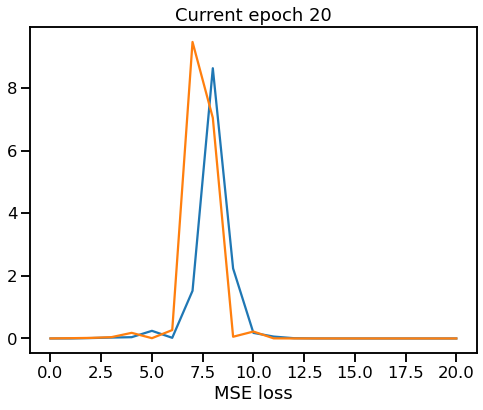

In [74]:
n_epochs=20 +1
batch_size= 1000
loss_train, loss_test = [], []
v_animate=1

n_batches = len(data)//batch_size
training_data = Tensor(data[:batch_size*n_batches].reshape((n_batches, batch_size, 3,1)))
test_data = training_data[round(n_batches*0.8)+1:]
training_data = training_data[:round(n_batches*0.8)+1]


for epoch in range(n_epochs):
    epoch_loss=0
    for i, batch in enumerate(training_data):
        
        opt.zero_grad()

        loss = mse_loss(model(batch),batch)

        loss.backward()
        opt.step()
        epoch_loss += loss.item()
        #print("[Epoch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, d_loss.item(), g_loss.item()))
        # plt.figure()
        # plt.plot(arr_i, arr_g_loss, label='G_loss')
        # plt.plot(arr_i, arr_d_loss, label='D_loss')
        # plt.legend();
    loss_train.append(epoch_loss/(i+1))
    loss_test.append(mse_loss(model(test_data.reshape(-1,3,1)), test_data.reshape(-1,3,1)))
    # clear_output(wait=True)
    # print(f'epoch {epoch} \nloss {loss.item()}')
    if epoch % v_animate == 0:
        clear_output(wait=True)
        print(f'epoch {epoch} \nloss {loss.item()}')
        plt.figure(figsize=(8,6))
        plt.plot(np.arange(epoch+1), loss_train)
        plt.plot(np.arange(epoch+1), loss_test)
        plt.title(f'Current epoch {epoch}')
        plt.xlabel('n_epochs')
        plt.xlabel('MSE loss')
        plt.show()

## Check models' quality

In [75]:
sum((model(training_data.reshape(-1,3,1)).round()-training_data.reshape(-1,3,1))**2)

tensor([[ 0.],
        [11.],
        [ 0.]], grad_fn=<AddBackward0>)

In [76]:
sum((model(test_data.reshape(-1,3,1)).round()-test_data.reshape(-1,3,1))**2)

tensor([[0.],
        [7.],
        [0.]], grad_fn=<AddBackward0>)

In [79]:
model(Tensor([0,0,0]).reshape(-1,3,1)).round()

tensor([[[0.],
         [-0.],
         [-0.]]], grad_fn=<RoundBackward0>)

## Saving and loading the model

In [ ]:
torch.save(model.state_dict(), 'embedding_model_with_zeros.pt')

In [18]:
model2 = AutoEncoder(protdim=2, locdim=2, aadim=2)
model2.load_state_dict(torch.load('embedding_model.pt'))
model2.eval()

AutoEncoder(
  (encoder): SubstitutionEncoding(
    (prot_encoder): BasicEncoding(
      (fc1): Linear(in_features=1, out_features=2, bias=True)
      (fc2): Linear(in_features=2, out_features=2, bias=True)
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (loc_encoder): BasicEncoding(
      (fc1): Linear(in_features=1, out_features=2, bias=True)
      (fc2): Linear(in_features=2, out_features=2, bias=True)
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (aa_encoder): BasicEncoding(
      (fc1): Linear(in_features=1, out_features=2, bias=True)
      (fc2): Linear(in_features=2, out_features=2, bias=True)
      (activation): LeakyReLU(negative_slope=0.01)
    )
  )
  (decoder): SubstitutionDecoding(
    (prot_decoder): BasicDecoding(
      (fc1): Linear(in_features=2, out_features=2, bias=True)
      (fc2): Linear(in_features=2, out_features=1, bias=True)
      (rl): LeakyReLU(negative_slope=0.01)
      (sm): Softmax(dim=0)
    )
    (loc_decoder): BasicDecoding(

In [120]:
substs = load_numpy('substs.npy')
substs

array(['NSP3_F1397L', 'NSP3_A488S', 'NSP3_P1469S', ..., 'NS3_Q57H',
       'NS8_S24L', 'N_Q289H'], dtype='<U12')

In [24]:
i = 10
s = substs[i]
print(s)
print(pre_encode(s, prot_le, aa_le))
print(model(Tensor(pre_encode(s, prot_le, aa_le)).reshape(1,3,1)).round().reshape(1,3))

NameError: name 'substs' is not defined

In [52]:
def autoencode(muts:np.array):
    for i in tqdm(range(len(muts))):
        muts[i] = pre_encode(muts[i], prot_le, aa_le)
    return muts

In [53]:
autoencode(substs[:10])

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


ValueError: setting an array element with a sequence

In [42]:
pre_encode(s, prot_le, aa_le)

array([  16, 1397,    9])

In [40]:
model(Tensor(pre_encode(s, prot_le, aa_le)).reshape(1,3,1))

tensor([[[  16.0000],
         [1396.9990],
         [   8.9999]]], grad_fn=<ReshapeAliasBackward0>)

In [13]:
Input = batch[:80]
# Input, model(Input).round()

NameError: name 'batch' is not defined

In [205]:
model(Input)

tensor([[[  15.9987],
         [1168.2126],
         [  11.0000]],

        [[   2.9984],
         [ 112.9038],
         [   4.0000]]], grad_fn=<ReshapeAliasBackward0>)

In [204]:
encoded = model.encoder(Input)[:,:2]
encoded

tensor([[22.2205, -0.0578],
        [ 4.2556,  4.5340]], grad_fn=<SliceBackward0>)

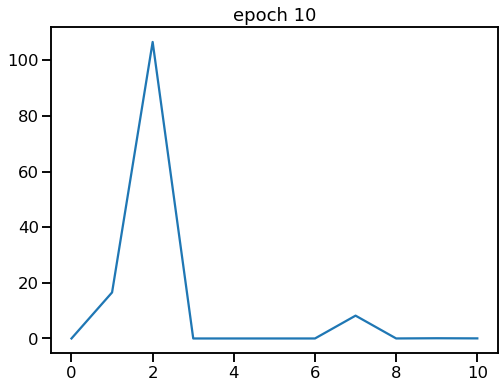

In [194]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(epoch+1), arr_loss)
plt.title(f'epoch {epoch}');

epoch 10 
loss 1.4898524568707217e-05


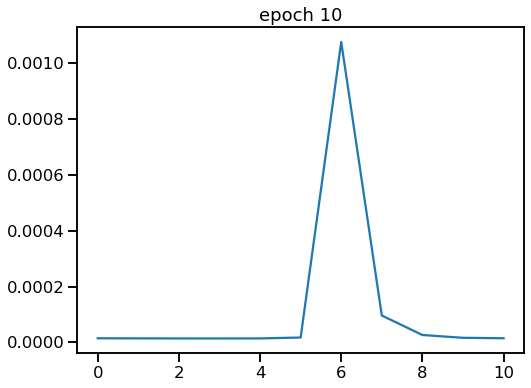

In [15]:
n_epochs=10 +1
batch_size= 1000
arr_loss = []
v_animate=1

n_batches = len(data)//batch_size
training_data = data[:batch_size*n_batches]
training_data = Tensor(training_data.reshape((n_batches, batch_size, 3,1)))

for epoch in range(n_epochs):
    for batch in training_data:
        
        opt.zero_grad()

        loss = mse_loss(model(batch),batch)

        loss.backward()
        opt.step()

        #print("[Epoch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, d_loss.item(), g_loss.item()))
        # plt.figure()
        # plt.plot(arr_i, arr_g_loss, label='G_loss')
        # plt.plot(arr_i, arr_d_loss, label='D_loss')
        # plt.legend();
    arr_loss.append(loss.item())
    # clear_output(wait=True)
    # print(f'epoch {epoch} \nloss {loss.item()}')
    if epoch % v_animate == 0:
        clear_output(wait=True)
        print(f'epoch {epoch} \nloss {loss.item()}')
        plt.figure(figsize=(8,6))
        plt.plot(np.arange(epoch+1), arr_loss)
        plt.title(f'epoch {epoch}')
        plt.show()

In [75]:
model.forward(Tensor([1, 1000, 159]).reshape(3,1))

tensor([[ 3.],
        [-1.],
        [ 6.]], grad_fn=<ResizeBackward>)

In [50]:
dec = BasicDecoding(indim=5, outdim=1)
dec(Tensor([2.7163e-01,2.3010e-01, 3.9317e-01, 8.9747e-01, 8.9454e-01, ]))

tensor([1.], grad_fn=<RoundBackward0>)

In [52]:
loc_enc = SubstitutionEncoding()
tens= loc_enc.forward(Tensor([1, 2, 159]).reshape(3,1))
tens

tensor([4.3248e-01, 4.6745e-01, 4.8443e-01, 6.4873e-01, 6.5034e-01, 1.6462e-01,
        8.9973e-01, 7.4749e-01, 6.2651e-01, 6.1945e-01, 1.0000e+00, 9.5524e-34,
        1.0000e+00, 0.0000e+00, 1.0000e+00], grad_fn=<CatBackward0>)

In [53]:
loc_dec = SubstitutionDecoding()
loc_dec(loc_enc.forward(Tensor([1, 2, 159]).reshape(3,1)))

tensor([[20.],
        [ 1.],
        [ 5.]], grad_fn=<ResizeBackward>)

In [28]:
def pre_encode(s, prot_le_, aa_le_):
    prot, subst = s.split('_')
    return np.array([prot_le_[prot], int(subst[1:-1]), aa_le_[subst[-1]]])

In [33]:
data = []
for elem in tqdm(a):
    data.append(pre_encode(elem, prot_le_=prot_le, aa_le_=aa_le))
data = np.array(data)

100%|████████████████████████████████████████████████████████████████████████| 23429/23429 [00:00<00:00, 154155.13it/s]


In [37]:
with open('substs_preenc.npy', 'wb') as f:
    np.save(f, data)
    
with open('substs_preenc.npy', 'rb') as f:
    data = np.load(f)

In [38]:
len(data)

23429

In [26]:
data = pd.read_csv('demo.csv')
data = data['combineMuts']
data.head()

0    NSP3_F1397L,NSP3_A488S,NSP3_P1469S,NSP3_D410G,...
1    NSP3_A488S,NSP3_P1469S,NSP3_P1228L,NSP4_A92V,N...
2    NSP1_S135R,NSP3_G489S,NSP3_T24I,NSP4_L264F,NSP...
3    NSP1_S135R,NSP3_G489S,NSP3_T24I,NSP4_L264F,NSP...
4    NSP1_M85del,NSP1_H83del,NSP1_V84del,NSP1_V86de...
Name: combineMuts, dtype: object

In [184]:
s

'NSP1_M85del,NSP1_H83del,NSP1_V84del,NSP1_V86del,NSP1_G82del,NSP3_L1266I,NSP3_S1265del,NSP3_K38R,NSP3_A1892T,NSP3_V1069I,NSP4_T492I,NSP5_P132H,NSP6_G107del,NSP6_S106del,NSP6_L105del,NSP6_I189V,NSP12_P323L,NSP14_I42V,NSP16_I128V,Spike_N679K,Spike_Q493R,Spike_Y145del,Spike_G339D,Spike_G446S,Spike_P681H,Spike_D614G,Spike_N969K,Spike_N764K,Spike_T478K,Spike_H655Y,Spike_G496S,Spike_N856K,Spike_N440K,Spike_Y144del,Spike_N211del,Spike_ins214EPE,Spike_A67V,Spike_S371L,Spike_Q498R,Spike_K417N,Spike_T547K,Spike_L981F,Spike_S375F,Spike_Q954H,Spike_S477N,Spike_N501Y,Spike_T95I,Spike_A701V,Spike_G142D,Spike_Y505H,Spike_D796Y,Spike_V143del,Spike_V70del,Spike_S373P,Spike_L212I,Spike_E484A,Spike_H69del,E_T9I,M_A63T,M_D3G,M_Q19E,N_R32del,N_S33del,N_E31del,N_G204R,N_P13L,N_R203K,'

In [188]:
s_arr = np.array(s.split(','))
s_arr

array(['NSP1_M85del', 'NSP1_H83del', 'NSP1_V84del', 'NSP1_V86del',
       'NSP1_G82del', 'NSP3_L1266I', 'NSP3_S1265del', 'NSP3_K38R',
       'NSP3_A1892T', 'NSP3_V1069I', 'NSP4_T492I', 'NSP5_P132H',
       'NSP6_G107del', 'NSP6_S106del', 'NSP6_L105del', 'NSP6_I189V',
       'NSP12_P323L', 'NSP14_I42V', 'NSP16_I128V', 'Spike_N679K',
       'Spike_Q493R', 'Spike_Y145del', 'Spike_G339D', 'Spike_G446S',
       'Spike_P681H', 'Spike_D614G', 'Spike_N969K', 'Spike_N764K',
       'Spike_T478K', 'Spike_H655Y', 'Spike_G496S', 'Spike_N856K',
       'Spike_N440K', 'Spike_Y144del', 'Spike_N211del', 'Spike_ins214EPE',
       'Spike_A67V', 'Spike_S371L', 'Spike_Q498R', 'Spike_K417N',
       'Spike_T547K', 'Spike_L981F', 'Spike_S375F', 'Spike_Q954H',
       'Spike_S477N', 'Spike_N501Y', 'Spike_T95I', 'Spike_A701V',
       'Spike_G142D', 'Spike_Y505H', 'Spike_D796Y', 'Spike_V143del',
       'Spike_V70del', 'Spike_S373P', 'Spike_L212I', 'Spike_E484A',
       'Spike_H69del', 'E_T9I', 'M_A63T', 'M_D3G', '

In [27]:
re.findall(r'\d+','F1397L')

['1397']

In [198]:
def is_subst(s):
    if 'ins' not in s and 'del' not in s:
        return True
    return False

In [200]:
substs = []
for i in range(len(data)):
    arr= data[i].split(',')
    for j in range(len(arr)-1):
        if is_subst(arr[j]):
            substs.append(arr[j])

In [215]:
def check_substs(s):
    a,b = s.split('_')
    if a in proteins and b[0] in amino_acids and b[-1] in amino_acids and b[1:-1].isdigit():
        return True
    return False

In [ ]:
for i in 

In [225]:
a,b = 'M_Q19Z'.split('_')
if b[-1] in amino_acids:# and b[1:-1].isdigit():
    print('YES')

In [230]:
amino_acids

['A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [233]:
substs_ = []
for i in substs:
    if check_substs(i):
        substs_.append(i)

In [ ]:
len(substs)

In [189]:
'ins' not in s_arr

True

In [234]:
with open('substs.npy', 'wb') as f:

    np.save(f, np.array(substs_))

In [26]:
import re
re.findall(r'\d+',''.join(re.findall(f'_\w\d+\w', s)))

NameError: name 's' is not defined

In [178]:
''.join(re.findall(f'_\w\d+\w', s))

'_S135R_G489S_T24I_L264F_L438F_T327I_T492I_P132H_F108d_G107d_S106d_P323L_R392C_I42V_T112I_V213G_N679K_T376A_Q493R_D405N_G339D_R408S_T19I_P681H_D614G_N969K_N764K_T478K_H655Y_P26d_N440K_Q498R_K417N_S371F_A27S_S375F_Q954H_L24d_S477N_N501Y_G142D_Y505H_D796Y_P25d_S373P_E484A_T223I_T9I_A63T_Q19E_R32d_S413R_S33d_E31d_G204R_P13L_R203K'

In [59]:
aa = set()
for i in range(10000):
    s = data[i]
    for elem in (re.findall(fr'_\w\d+', s)):
        aa.add(elem[1])

In [62]:
print(list(aa))

['A', 'H', 'N', 'S', 'T', 'E', 'L', 'K', 'P', 'I', 'R', 'M', 'D', 'V', 'G', 'W', 'Y', 'Q', 'F', 'C']


In [53]:
(re.findall(fr'_\w\d+', s))

['_F1397',
 '_A488',
 '_P1469',
 '_D410',
 '_P1228',
 '_V167',
 '_T492',
 '_T77',
 '_C197',
 '_P323',
 '_G671',
 '_P77',
 '_A394',
 '_T19',
 '_P681',
 '_D614',
 '_D950',
 '_T478',
 '_L452',
 '_F157',
 '_R158',
 '_E156',
 '_E239',
 '_S26',
 '_I82',
 '_V82',
 '_T120',
 '_T40',
 '_G215',
 '_D377',
 '_D63',
 '_R203',
 '_T1160']